In [2]:

from statistics import mean
import torch
from torch import nn
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import roc_curve as roc

In [11]:
import numpy as np

In [3]:
# https://towardsdatascience.com/lstms-in-pytorch-528b0440244
# https://github.com/IHCA-Coding-to-Prevent-Coding/ML-SampleNeuralNet/blob/main/sampleneuralnet.py
# data from https://archive.ics.uci.edu/ml/datasets/Power+consumption+of+Tetouan+city#

In [4]:
data = pd.read_csv('Tetuan City power consumption.csv')
data.columns

Index(['DateTime', 'Temperature', 'Humidity', 'Wind Speed',
       'general diffuse flows', 'diffuse flows', 'Zone 1 Power Consumption',
       'Zone 2  Power Consumption', 'Zone 3  Power Consumption'],
      dtype='object')

In [5]:
#first week of data is training, second week is testing

splitPoint = 144*7

trainTruth = data.iloc[:splitPoint, [6]]
training = data.iloc[:splitPoint, [1, 2, 3, 4, 5]]

testTruth = data.iloc[splitPoint:splitPoint*2, [6]]
testing = data.iloc[splitPoint:splitPoint*2, [1, 2, 3, 4, 5]]

trainTruth = torch.tensor(trainTruth.values)
training = torch.tensor(training.values)

testTruth = torch.tensor(testTruth.values)
testing = torch.tensor(testing.values)

training = training.float()
testing = testing.float()
trainTruth = trainTruth.float()
testTruth = testTruth.float()

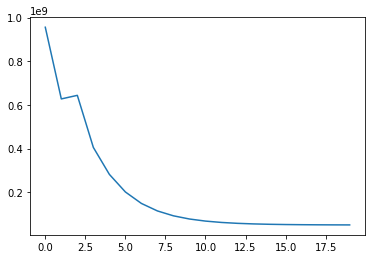

In [33]:
#testing = torch.randn(batchSize, seqLength, inputSize)

inputSize=5 # variables input
lstmSize=32 # nodes of hidden layer
linearSize=16
outSize=1 # power consumptoion in zone 1
batchSize= 144*7 # how many data points are in batch
lr = 0.1
seqLength=144 # num of time values per input
epochSize = 20

class extractTensor(nn.Module):
    def forward(self, x):
        tensor, hs = x
        return tensor.reshape(-1, lstmSize) 

model = nn.Sequential(
    nn.LSTM(inputSize, lstmSize),
    extractTensor(),
    nn.Sigmoid(),
    nn.Linear(lstmSize, outSize)
)

def lossFunc(data=training, comparison=trainTruth, model=model):
    prediction = model(data)

    MSEloss = torch.nn.MSELoss()
    output = MSEloss(prediction, comparison)
    
    return output, prediction

optimizer = torch.optim.SGD(model.parameters(), lr=lr)

lossList = []
for i in range(epochSize):
    loss, output = lossFunc()
    lossList.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

plt.plot(lossList)
training_loss = loss.item();

In [34]:
with torch.no_grad():
    testing_loss, prediction = lossFunc(testing, testTruth);
    testing_loss = testing_loss.item()
   
    print(f"training loss:    {training_loss}");
    print(f"testing loss:     {testing_loss}");
    print(f"testing-training: {testing_loss-training_loss}");
    print(f"testing/training: {training_loss/testing_loss}");
    print(f"% error           {(testing_loss-training_loss)/testing_loss}");

training loss:    49860208.0
testing loss:     52785040.0
testing-training: 2924832.0
testing/training: 0.944589754976031
% error           0.055410245023968914


In [12]:
# https://towardsdatascience.com/how-to-calculate-roc-auc-score-for-regression-models-c0be4fdf76bb

# continuous auroc calculator from the internet
def regression_roc_auc_score(y_true, y_pred, num_rounds = 10000):
  """
  Computes Regression-ROC-AUC-score.
  
  Parameters:
  ----------
  y_true: array-like of shape (n_samples,). Binary or continuous target variable.
  y_pred: array-like of shape (n_samples,). Target scores.
  num_rounds: int or string. If integer, number of random pairs of observations. 
              If string, 'exact', all possible pairs of observations will be evaluated.
  
  Returns:
  -------
  rroc: float. Regression-ROC-AUC-score.
  """

    
  y_true = np.array(y_true)
  y_pred = np.array(y_pred)

  num_pairs = 0
  num_same_sign = 0
  
  for i, j in _yield_pairs(y_true, num_rounds):
    diff_true = y_true[i] - y_true[j]
    diff_score = y_pred[i] - y_pred[j]
    if diff_true * diff_score > 0:
      num_same_sign += 1
    elif diff_score == 0:
      num_same_sign += .5
    num_pairs += 1
      
  return num_same_sign / num_pairs


def _yield_pairs(y_true, num_rounds):
  """
  Returns pairs of valid indices. Indices must belong to observations having different values.
  
  Parameters:
  ----------
  y_true: array-like of shape (n_samples,). Binary or continuous target variable.
  num_rounds: int or string. If integer, number of random pairs of observations to return. 
              If string, 'exact', all possible pairs of observations will be returned.
  
  Yields:
  -------
  i, j: tuple of int of shape (2,). Indices referred to a pair of samples.
  
  """
  
  if num_rounds == 'exact':
    for i in range(len(y_true)):
      for j in np.where((y_true != y_true[i]) & (np.arange(len(y_true)) > i))[0]:
        yield i, j     
  else:
    for r in range(num_rounds):
      i = np.random.choice(range(len(y_true)))
      j = np.random.choice(np.where(y_true != y_true[i])[0])
      yield i, j

In [35]:
# use sklearn for auroc curve
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
    # roc curve docs
    # integral of above is auroc
# need binary values for above
    # get from seeing if prediction is in error range of truth value
    # 5% of average power usage??

#assigning predictions to true or false based on error range

#TODO roc meant to use binary true/dalse values not continuous data
    #change data setup to binary prediction?
        # chance city will use more than average power??
'''
isCorrect =[]
for i in range(len(prediction)):
    if (prediction[i] <= testTruth[i] + errorRange) and (prediction[i] >= testTruth[i] - errorRange):
        isCorrect.append(1)
    else:
        isCorrect.append(0)


plt.plot(roc([1]*len(isCorrect), isCorrect))
'''

print(f"AUROC value: {regression_roc_auc_score(testTruth, prediction)}")

AUROC value: 0.50095
